# Car Detection Using YOLOV5
## 자율주행 
자율 주행은 기술 수준에 따라 여섯 단계로 분류 되어 있으며, 현재는 자율 주행 2~3단계에 머무르고 있어, 아직까지는 운전자의 개입으로 운전이 되는 주행 단계에 있습니다. 자율 주행 4단계를 실현시키기 위해서 기술을 개발하고 있는 단계에 있습니다. 

이러한 자율 주행을 이해하고 자율 주행을 실현시키기 위한 단계로 딥러닝 기반 객체 탐지를 실현시켜보았습니다. 

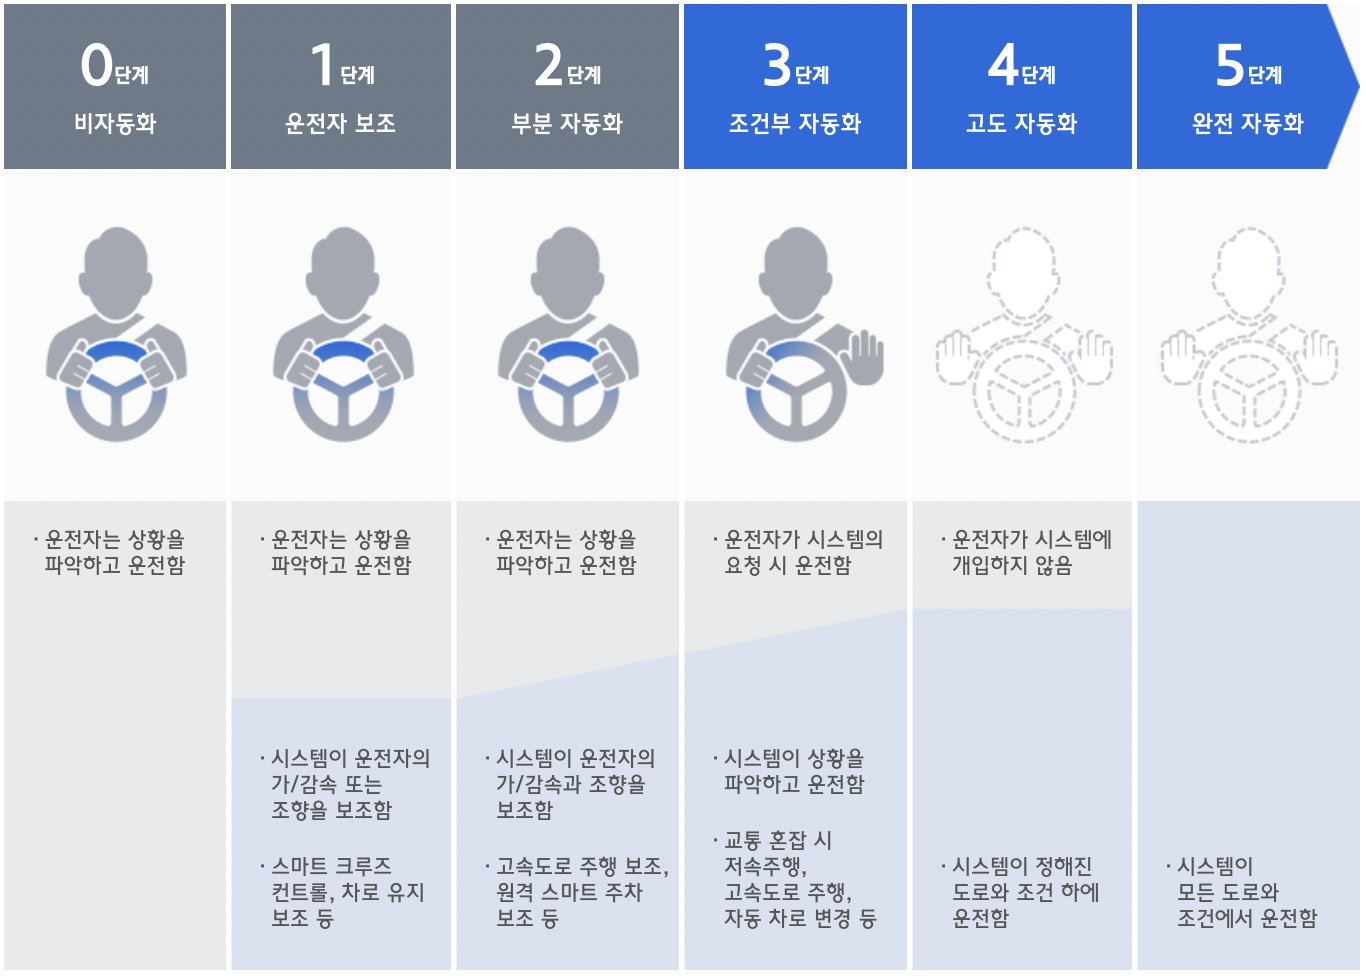

그 중 Yolo를 통해 자율 주행 자동차의 Object Detection을 실현시켰습니다. 
YOLO(You Only Look Once) 는 one-stage object Detection 딥러닝 기법으로 Real Time Object Detection이 가능하도록 만들어졌습니다. 

각 이미지를 S * S 개의 Grid 로 분할하고, 각 Grid 의 신뢰도를 계산합니다. 처음에는 객체와 동떨어진 Grid 가 설정되지만, 신뢰도를 계산하여 위치를 조정함으로써 가장 높은 객체 인식의 정확성을 가지는 Grid를 얻게 됩니다. 
신뢰도는 주변 Grid를 합쳐서 높이고, 이후 임계값을 설정해서 불필요한 부분을 제거합니다. 

현재 YOLO는 다양한 버전이 공개되었고, YOLOV5 까지 출시 되어 있습니다. 

이 프로젝트에서는 YOLO V5 를 사용하여 객체 인식을 진행하였습니다. 

## 데이터를 이용한 가설
다양한 데이터 셋이 존재하고 있지만, 저는 실제로 자동차가 주행하고 있는 관점에서 바라 보았을 때, 다른 자동차를 인식할 수 있는 데이터를 찾아서 진행하기로 하였습니다. 
하지만 그에 알맞은 데이터 및 제가 원하는 데이터가 없었기 때문에 직접 데이터를 수집하고 가공하게 되었습니다. 

데이터는 유튜브에 있는 '주간주행영상'을 활용하게 되었습니다. 

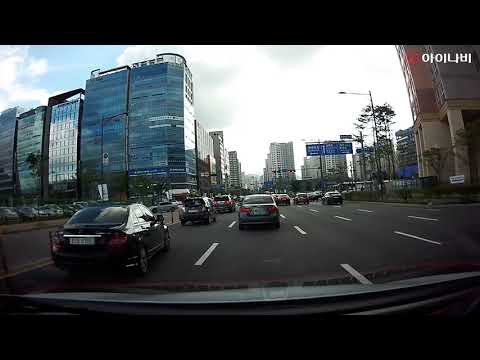

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('-cSrUiAjUlM',width=600,height=360)

위 영상을 다운로드 받아서 저장 후, 코드를 사용하여 동영상의 프레임을 이미지로 변환시켜주었습니다.
```
# 동영상을 프레임으로 변환하여 저장
import cv2
cap = cv2.VideoCapture('./driving.mp4') # 다운 받은 영상 파일명

# 비디오 프레임 크기, 전체 프레임수, FPS 등 출력
print('Frame width:', int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)))
print('Frame height:', int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
print('Frame count:', int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))
print('FPS:', cap.get(cv2.CAP_PROP_FPS))

count = 0
while cap.isOpened():
    ret, frame = cap.read()
    # frame = cv2.resize(frame, (416,416))
    
    # 10 frame 당 하나씩 이미지 추출
    if int(cap.get(1))%10 == 0:
        cv2.imwrite('./export/images/image%d.jpg'%count, frame)

        count += 1
        
    if count == 179:
        break
        
print(count)
cap.release()
```

확인 결과 :
```
Frame width: 640
Frame height: 360
Frame count: 1799
FPS: 29.970146468887023
179
```
동영상은 1분 짜리 영상이고, 영상의 fps(Frames per Second)는 약 30fps로 1초당 30 프레임을 보여줍니다. 
총 프레임의 수는 1799로 만약 이 영상의 모든 프레임을 이미지로 만들어 저장하게 되면 학습하는 시간이 오래 걸릴 것이라고 생각하게 되어, 10 프레임 당 하나의 이미지를 저장하는 방식으로 진행하게 되었고, 총 179 개의 이미지가 생성되어 저장되었습니다. 

## YOLO V5 를 위한 데이터셋 제작
YOLO를 사용하기 위해서는 그에 맞는 데이터셋이 준비되어 있어야 합니다. 
이미지와 상응하는 라벨링이 되어있어야 하며, 라벨링을 하기 위해서 `labelimg` 툴을 사용하였습니다. 
`lableimg` 를 활용하여 이미지에 존재하는 객체를 라벨링 해주었습니다. 

간단한 객체 인식을 위해서 이미지에 존재하는 자동차만을 인식할 수 있도록 이미지에 존재하는 차는 전부 'car' 로 labelling 해주었습니다. 

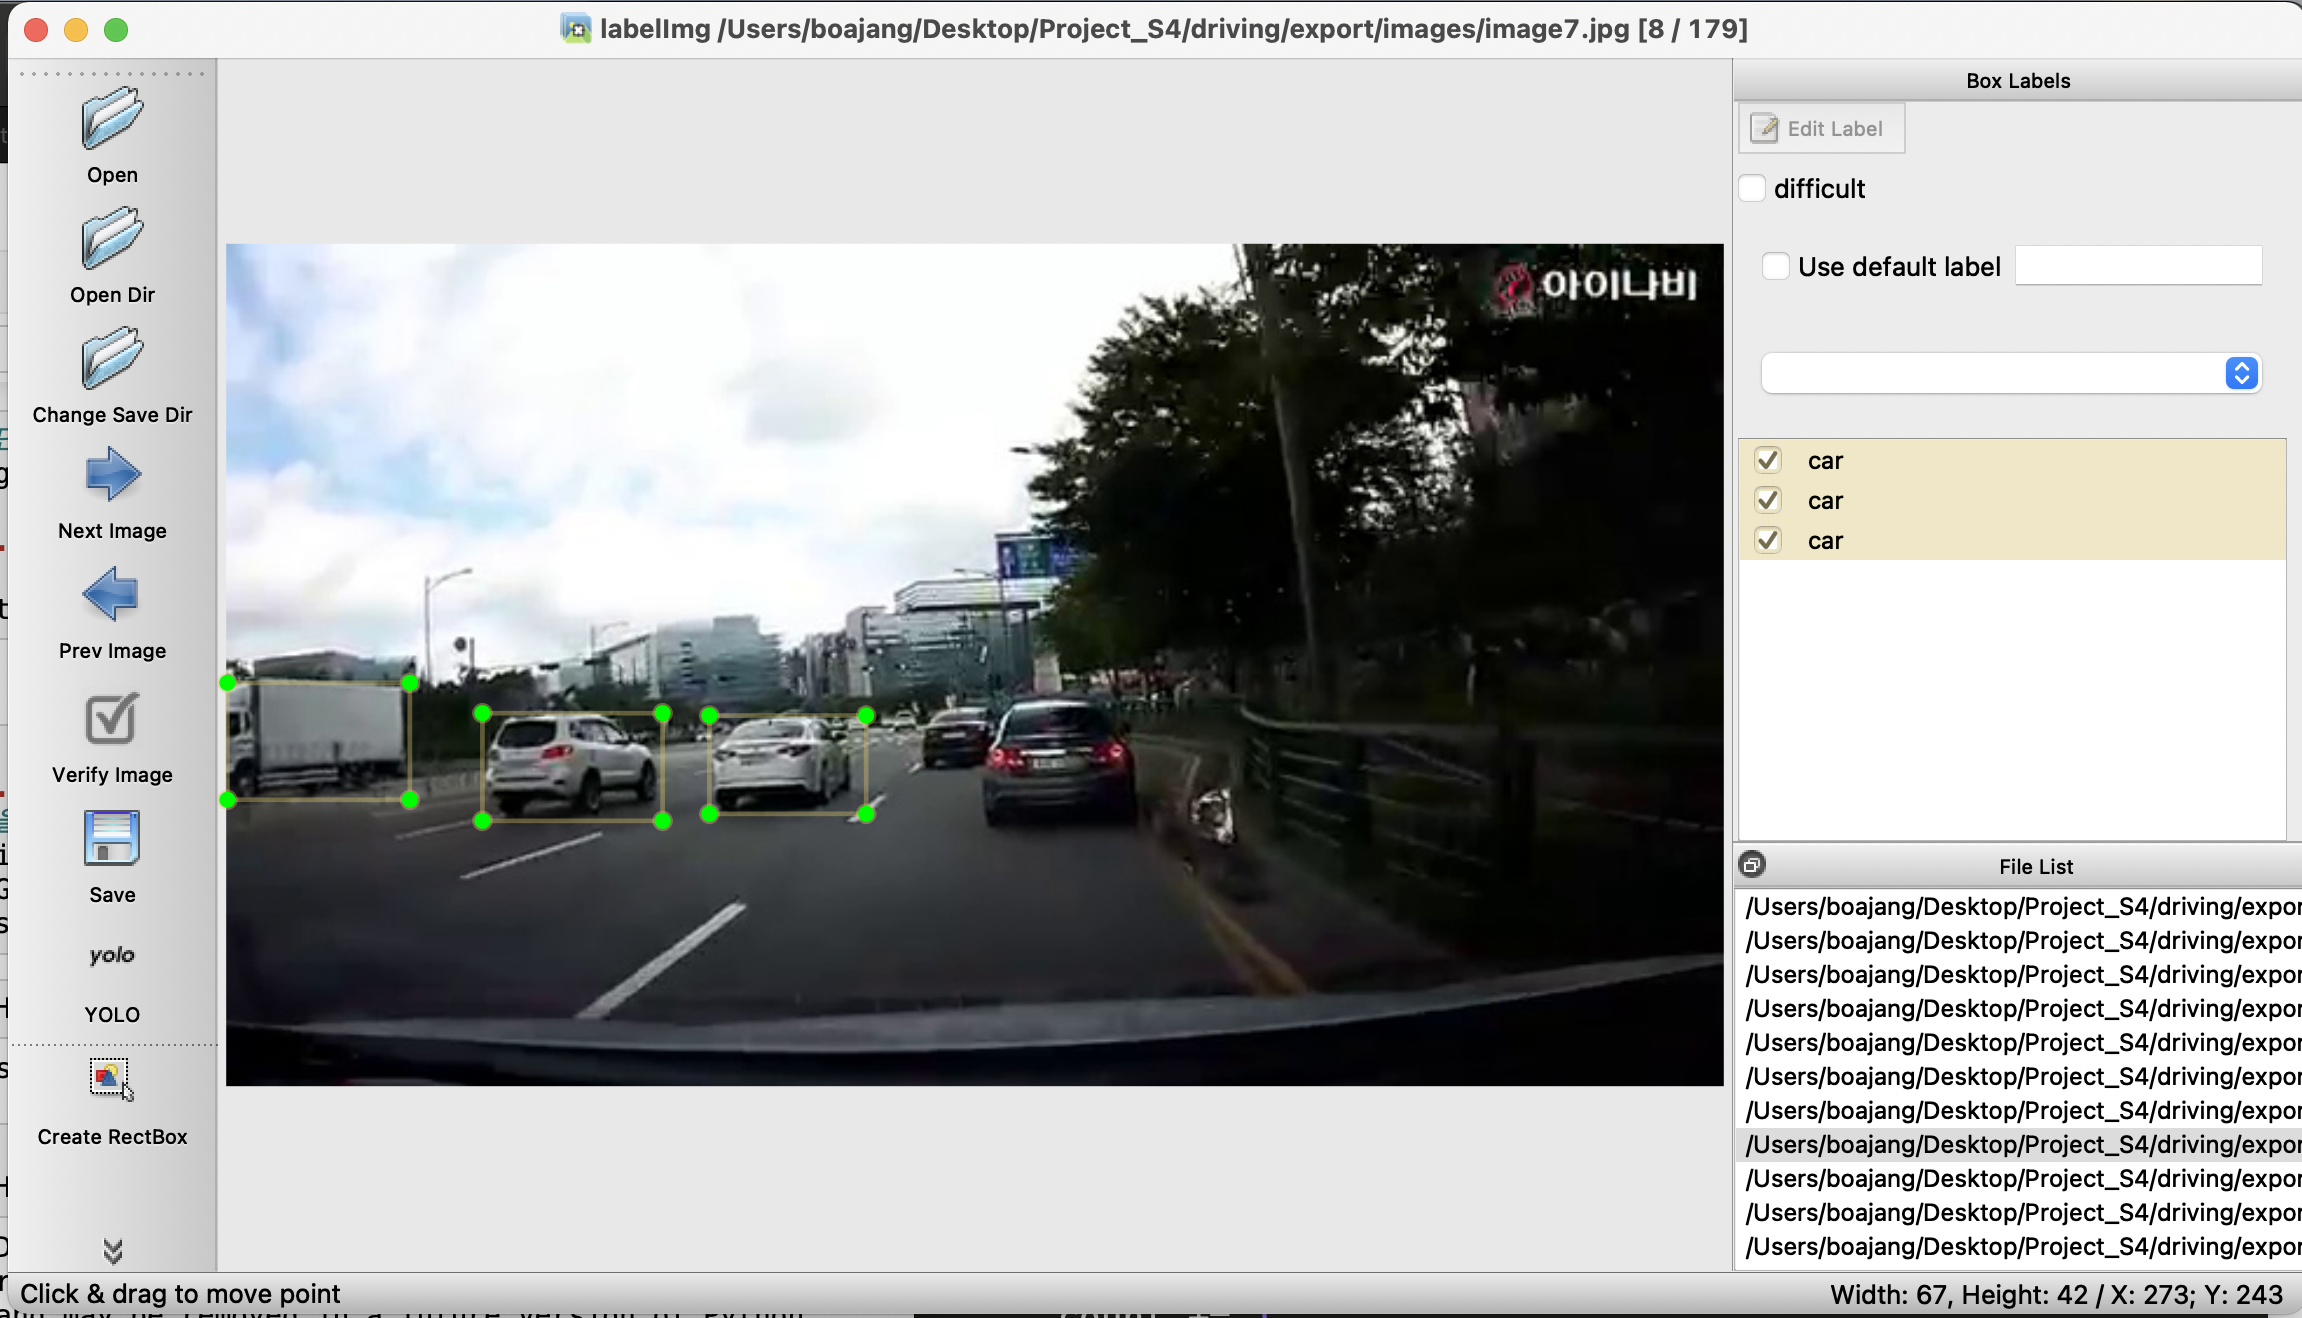

## 이미지 데이터를 학습 데이터와 검증 데이터로 나누기
179개의 이미지들은 하나로 묶여있어 학습과 테스트를 진행하기 위해서 학습 데이터와 검증 데이터로 나누어 주었습니다. 


```
# 이미지가 몇개인지 판단 및 list로 변환 
from glob import glob

# glob() 함수는 인자로 받은 패턴과 이름이 일치하는 모든 파일과 디렉토리의 리스트를 반환
img_list = glob('./export/images/*.jpg')

print(len(img_list))

# 확인 결과 Output: 179
```

```
# split data to train and val 
from sklearn.model_selection import train_test_split

train_img_list, val_img_list = train_test_split(img_list, test_size=0.2, random_state=42)

print(len(train_img_list),len(val_img_list))

# 확인 결과 Output: 143 36
```

학습 데이터는 143개, 검증 데이터는 36개로 나누어지게 되었습니다.

## YOLO V5 를 위한 yaml file 
YOLO V5를 활용하기 위해서는 학습 데이터의 경로, 클래스 갯수 및 종류가 적혀있는 yaml 파일이 필요합니다. 

제가 작성하게 된 yaml 파일의 형태는 
```
train: ./train.txt # 학습 데이터의 폴더 경로
val: ./val.txt # 검증 데이터의 폴더 경로 

nc: 1 # 클래스의 갯수
names: ['car'] # 클래스의 종류
```
로 YOLO 학습을 위해서 정리해주었습니다. 


## YOLO V5 학습하기 
YOLO v5를 사용하기 위해서는 깃헙 폴더를 클론해야 하며 또한 그에 필요한 라이브러리들을 설치해주어야 합니다. 
```
# code clone
git clone https://github.com/ultralytics/yolov5.git

# yolov5를 위한 패키지 설치
! pip install -r requirements.txt
```


YOLO V5 를 학습 하게 될 때는 아래의 코드로 학습을 진행할 수 있습니다. 
```
python train.py --data data.yaml --cfg yolov5s.yaml --weights '' --batch 64
                                       yolov5m                           40
                                       yolov5l                           24
                                       yolov5x 
```
제가 실행한 코드는: 
```
!python train.py --img 640 --batch 16 --epochs 50 --data ./data.yaml --cfg ./models/yolov5s.yaml --weights yolov5s.pt --name driving_yolov5s_results

```
batch size는 16으로 지정하였고, epochs 는 50으로 설정하게 되었습니다.
또한 Yolo v5는 s,m,l,x 의 4가지 버전이 존재하며, s는 가장 가벼운 모델, x는 가장 무거운 모델로, 이 프로젝트에서는 s 버전을 활용하여 진행하였습니다. 
당연히 s는 성능이 가장 낮지만 fps가 가장 높기에, 가벼운 영상을 돌리기에는 충분할 것이라고 판단하였습니다. 

학습 시간은 총 3.936 hours 걸렸습니다. 

## 학습 결과 및 테스트

**Confusion Matrix Results**
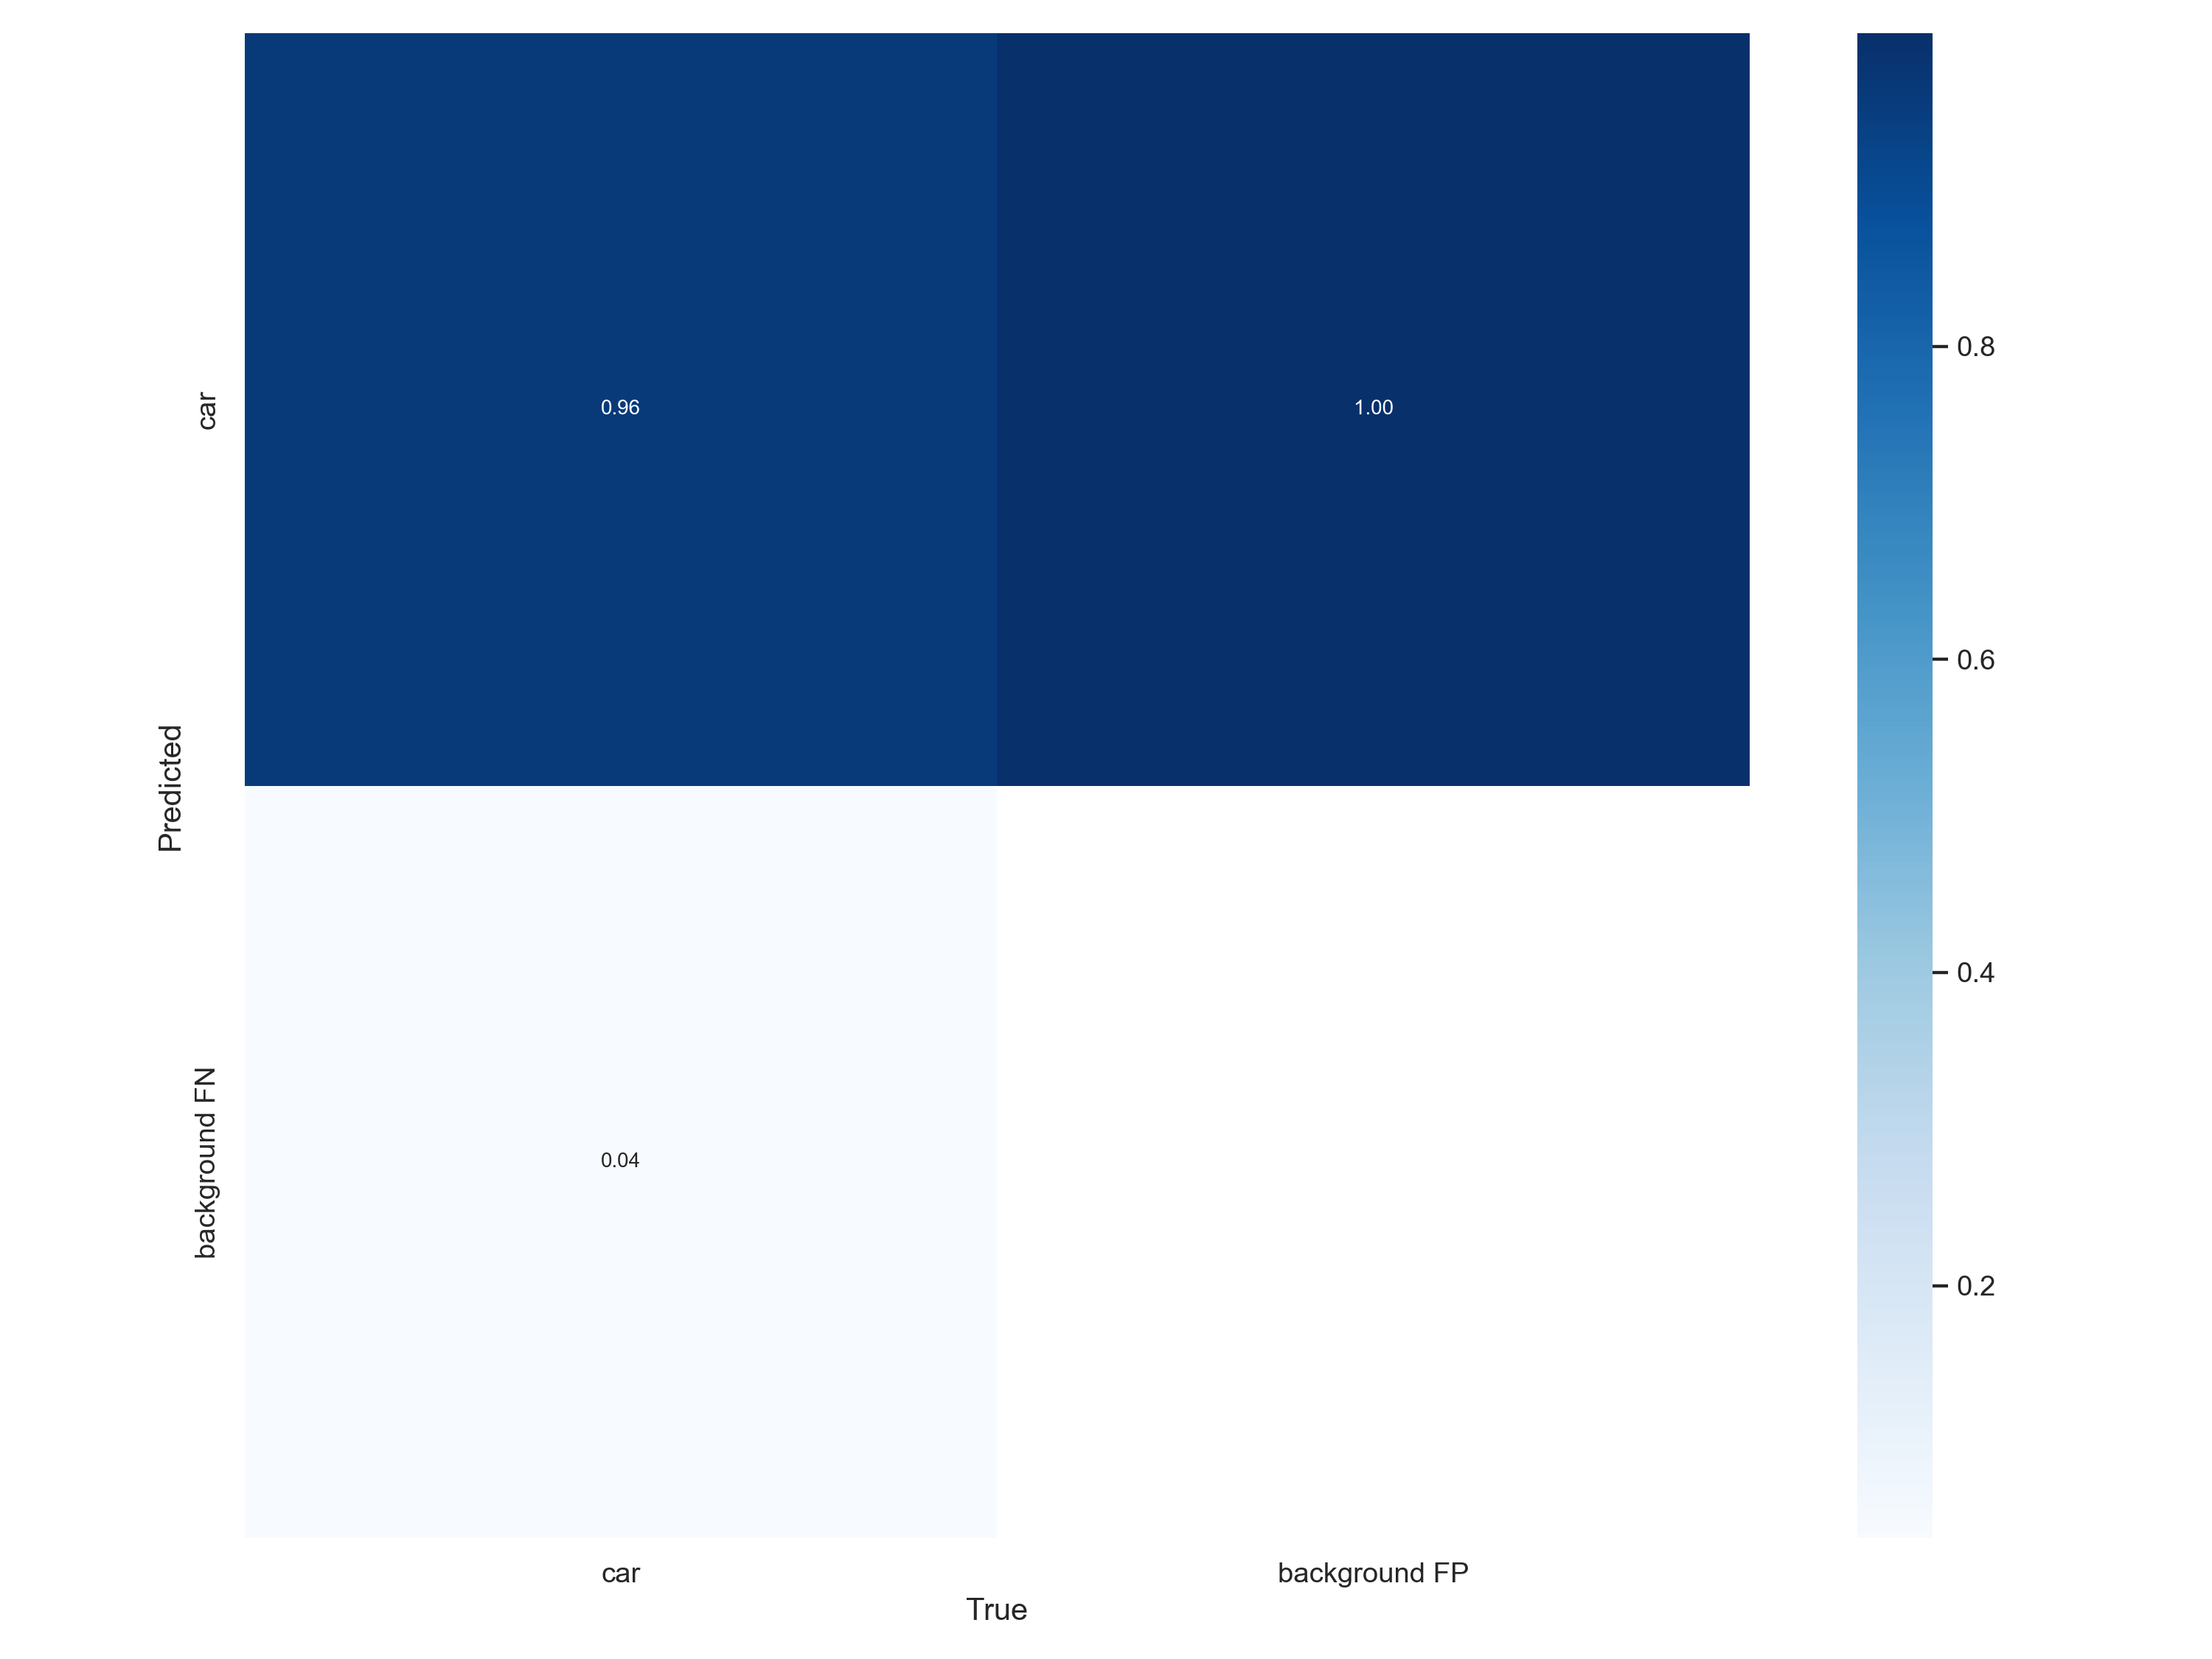

**F1 Curve**
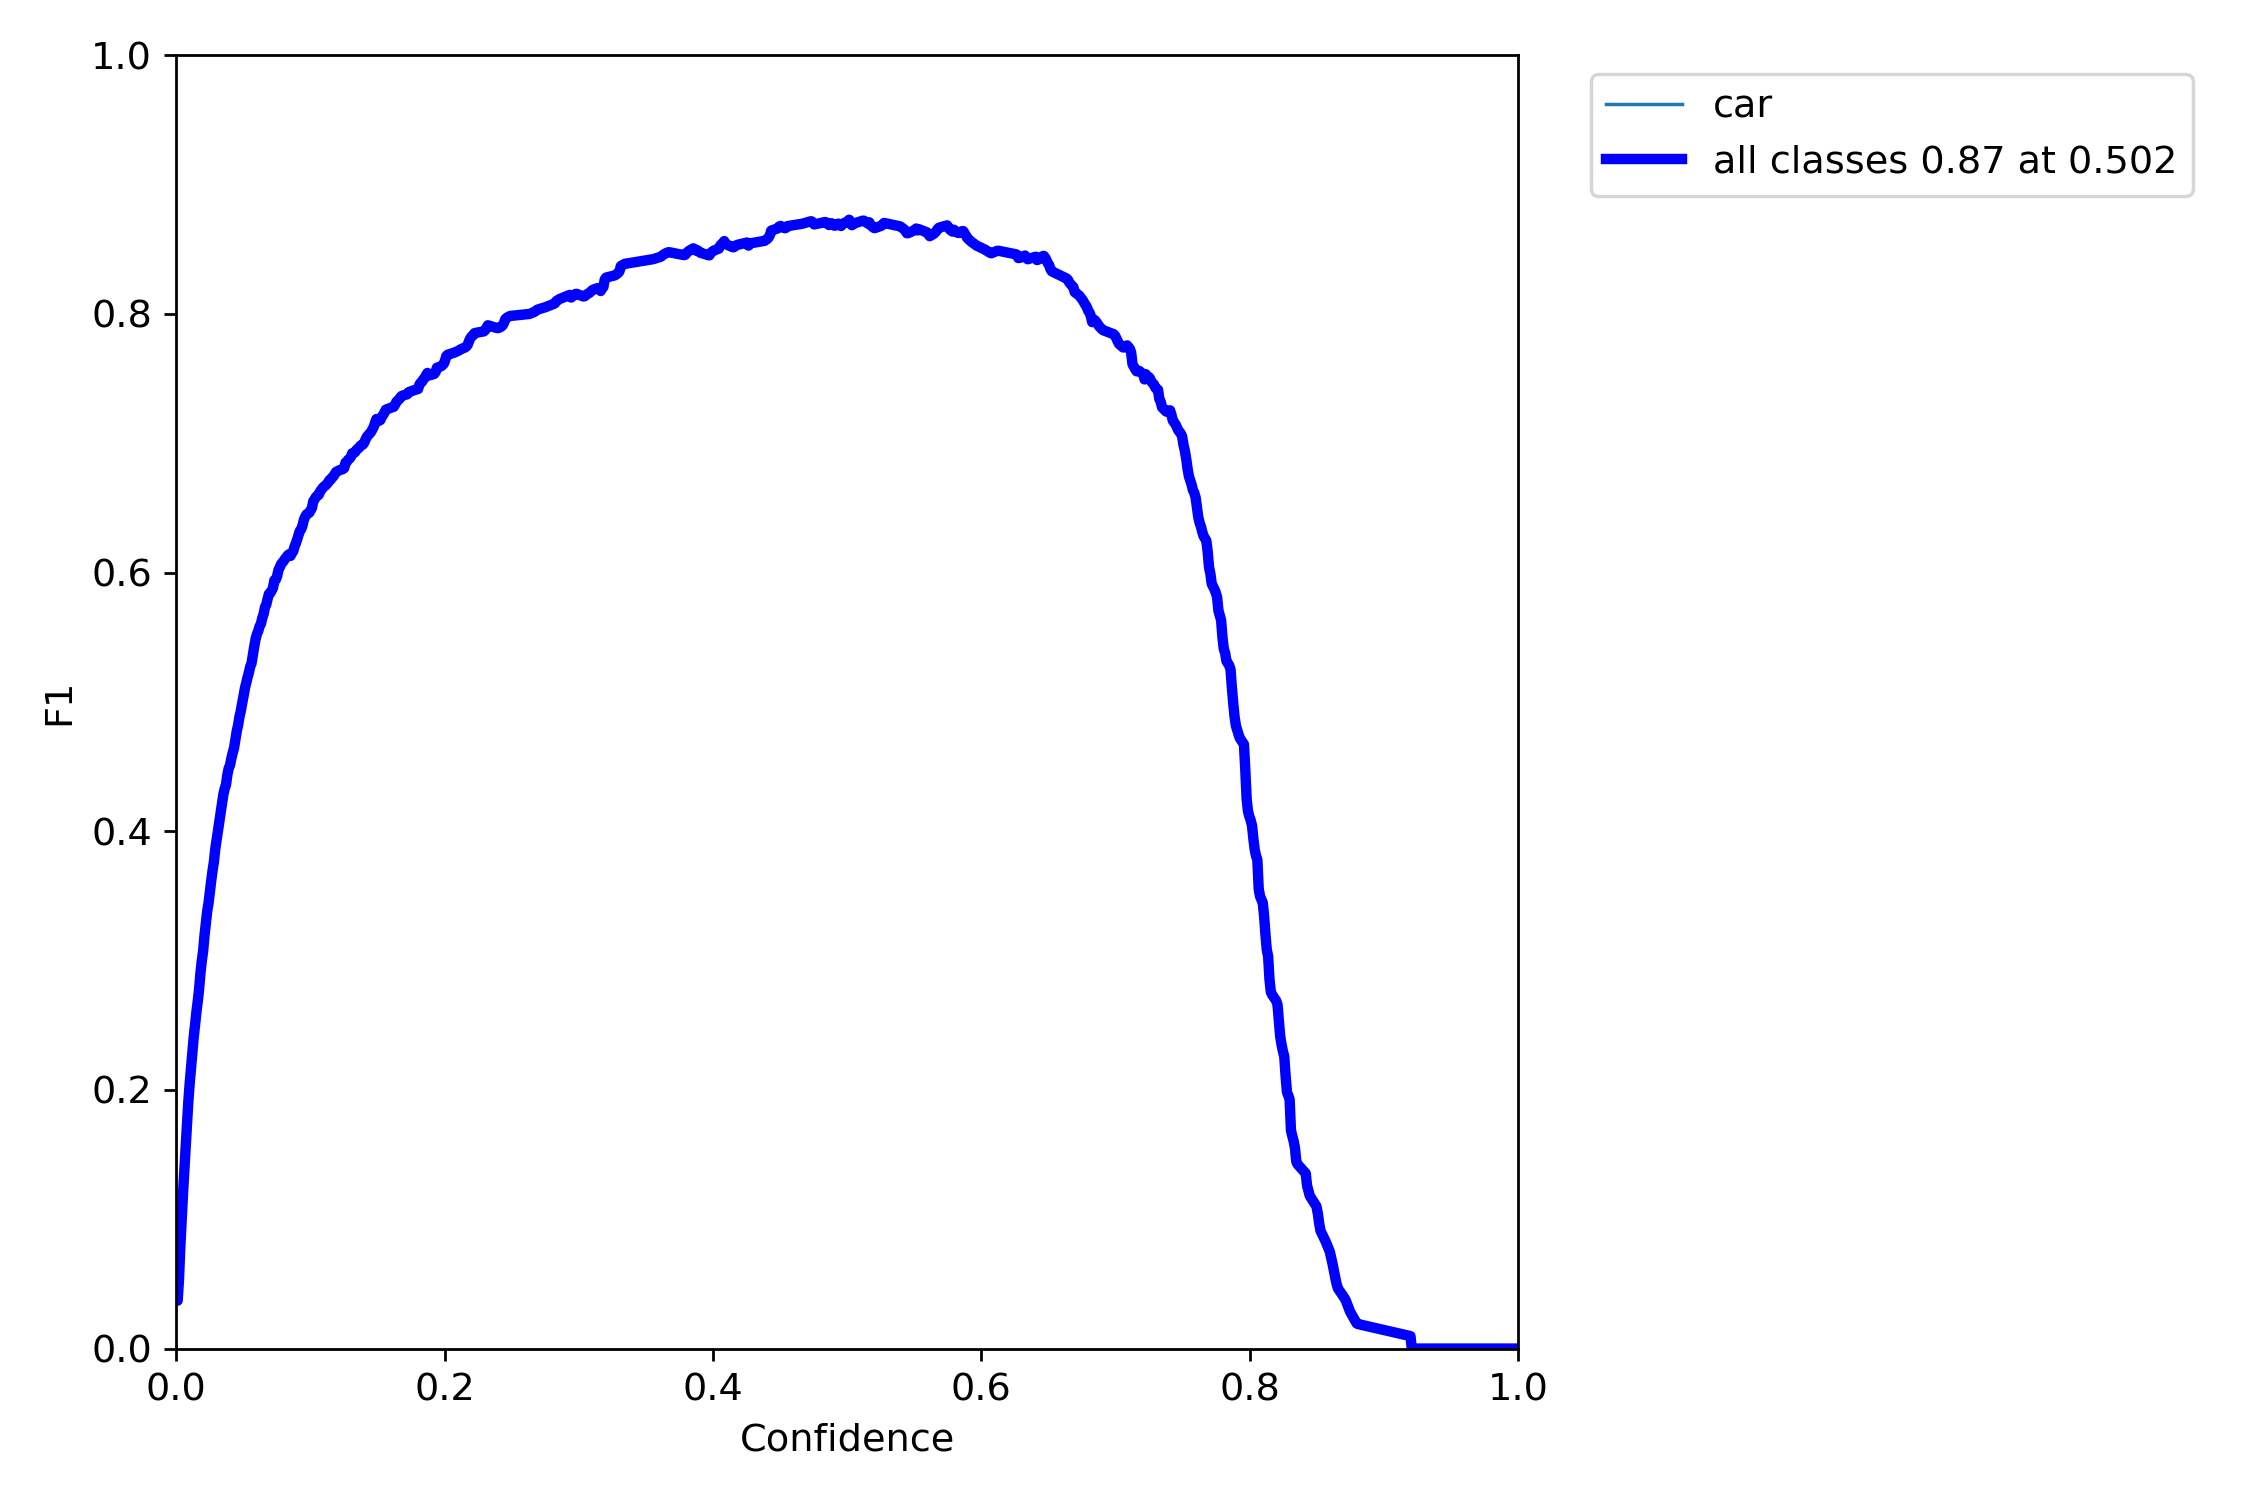

**Results of Detection**

Validation Image

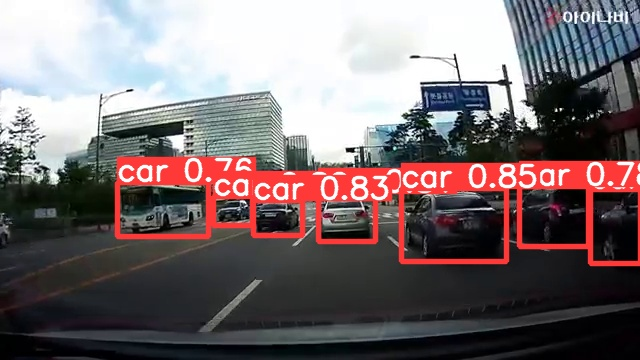

**Results of Video**
<br><br><br><br><br>

**Results of Other Image**


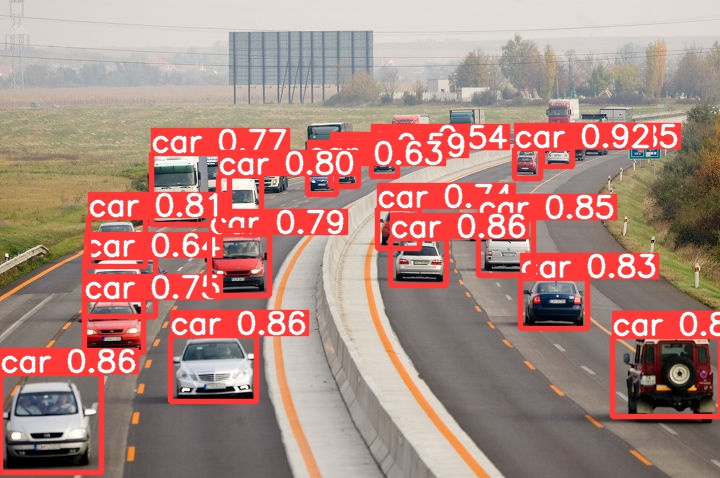

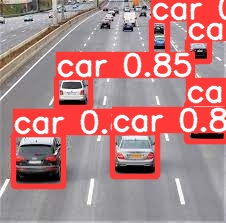

## 결론 및 정리
YOLO V5는 객체 탐지를 위해서 잘 구현이 되어 있는 모델로 자신의 데이터를 활용하였을 때 좋은 성능의 객체 인식을 진행할 수 있습니다. YOLO V5를 활용하여 다양한 어플리케이션을 구축할 수 있을 것이라고 생각합니다. 

더 좋은 성능의 객체 인식 및 탐지 모델을 구현하기 위해서는 현재 구현이 되어 있는 모델의 구조를 파악하고, 이를 활용하여 더 좋은 성능의 모델을 만들어야 합니다. 자율 주행에 객체 인식 기술을 더 잘 구현하기 위해서는 Pytorch 와 Tensorflow의 모델을 잘 활용하는 것도 중요하다고 생각하며, 자율 주행을 더욱 실현 시키기 위해서는 이후에 필요한 기술이 무엇인지 파악하고 현재 진행되고 있는 모델과 기술을 활용할 수 있어야 한다고 생각합니다. 

잘 만들어진 YOLO V5를 활용하여 자신의 데이터에 적용하기 까지 쉬운듯 하였으나 중간중간 예상치 못한 에러와 어려움으로 많은 시간과 공부를 하게 되었습니다. LabelImg 프로그램을 활용하여 라벨링을 하는 것도 예상외로 많은 시간과 많은 주의할 점이 있었습니다.

현재 구현되어 있는 Pytorch 혹은 Tensorflow의 모델을 잘 활용하고 자신의 문제에 알맞게 세팅하여 적용하게 된다면 좋은 성능의 모델을 구현하고 좋은 어플리케이션을 만들 수 있을 것이라고 생각합니다. 
